# LSTM with Keras

# TensorflowでGPUを使うには

[GPUサポート](https://www.tensorflow.org/install/gpu?hl=ja#windows_setup)

**cuDNN64_7.dll**がないとTensorflowは読み込まれません。<br>
これに対応するCUDAは**ver 10.1**以下です。

## GPUチェック

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 20199572808024635,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6063247873442990819
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6507127385
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7396545939738400031
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6981871880959683135
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
import numpy as np
from keras.utils import np_utils
from IPython.display import display, Audio

In [3]:
datasets_dir = "C:/Users/zankyo/Desktop/yamamoto/ERNN/datasets.npz"
datasets = np.load(datasets_dir)

In [4]:
data, label = datasets['data'].astype('float32'), datasets['label'].astype('float32')

x_train, y_train = data[:14000], label[:14000]
x_val ,y_val = data[14000:15000], label[14000:15000]
x_test, y_test = data[15000:], label[15000:]

In [5]:
print(x_train.shape,x_val.shape,x_test.shape)

(14000, 127, 512) (1000, 127, 512) (600, 127, 512)


In [6]:
# 使用するモジュールのインポート
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.layers.recurrent import LSTM
from keras import optimizers,regularizers

# Sequentialオブジェクトを生成
model = Sequential()

model.add(
   InputLayer(input_shape=(127,512))#入口の設定
   )


weight_decay = 1e-4
model.add(LSTM(units=512, dropout=0.25, return_sequences=True))
model.add(LSTM(units=512, dropout=0.25, return_sequences=True))
model.add(LSTM(units=512, dropout=0.25, return_sequences=True,
              kernel_regularizer=regularizers.l2(weight_decay))
)

model.add(
   Dense(units=512,
         activation='sigmoid')
   )


model.compile(
   loss='mean_absolute_error',
   optimizer=optimizers.Adam(),    
   metrics=['accuracy']            
   )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 127, 512)          2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 127, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 127, 512)          2099200   
_________________________________________________________________
dense (Dense)                (None, 127, 512)          262656    
Total params: 6,560,256
Trainable params: 6,560,256
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train, 
                   batch_size=10, epochs=50,
                   verbose=1,          
                   validation_data=(   
                   x_val, y_val))

Epoch 1/50
1400/1400 [==============================] - 59s 42ms/step - loss: nan - accuracy: 0.0210 - val_loss: 0.1783 - val_accuracy: 0.0085
Epoch 2/50
1400/1400 [==============================] - 59s 42ms/step - loss: nan - accuracy: 0.0280 - val_loss: 0.3923 - val_accuracy: 0.0084
Epoch 3/50
1400/1400 [==============================] - 59s 42ms/step - loss: nan - accuracy: 0.0447 - val_loss: 0.5482 - val_accuracy: 0.0187
Epoch 4/50
1400/1400 [==============================] - 59s 42ms/step - loss: nan - accuracy: 0.0502 - val_loss: 0.7049 - val_accuracy: 0.0078
Epoch 5/50
1400/1400 [==============================] - 59s 42ms/step - loss: nan - accuracy: 0.0522 - val_loss: 0.7117 - val_accuracy: 0.0140
Epoch 6/50
1400/1400 [==============================] - 60s 43ms/step - loss: nan - accuracy: 0.0580 - val_loss: 0.6243 - val_accuracy: 0.0348
Epoch 7/50
1400/1400 [==============================] - 58s 41ms/step - loss: nan - accuracy: 0.0621 - val_loss: 0.7898 - val_accuracy: 0.0070

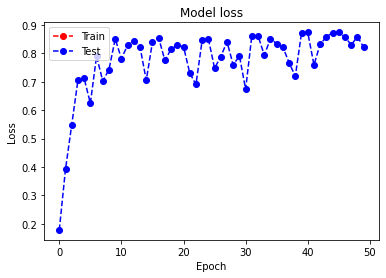

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], "ro--")
plt.plot(history.history['val_loss'], "bo--")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
predictions = model.predict(x_test)

In [17]:
def istft(X, win, step):
    M, N = X.shape
    assert (len(win) == N), "FFT length and window length are different."

    l = (M - 1) * step + N
    x = np.zeros(l,dtype="float64")
    wsum = np.zeros(l,dtype="float64")
    for m in range(M):
        start = step * m
        ### 滑らかな接続
        x[start : start + N] = x[start : start + N] + np.fft.ifft(X[m, :]).real * win
        wsum[start : start + N] += win ** 2 
    pos = (wsum != 0)
    x_pre = x.copy()
    ### 窓分のスケール合わせ
    x[pos] /= wsum[pos]
    return x

fftLen = 512 # とりあえず
win = np.hamming(fftLen) # ハミング窓
step = int(fftLen / 2)

In [46]:
predictions = model.predict(x_test) #モデルをつかった推定

i = 22

data = istft(predictions[i],win,step)
test_ = istft(x_test[i],win,step)
pp = predictions[i] * x_test[i]
_ss = istft(pp,win,step)

In [47]:
display(Audio(test_, rate=16000))
display(Audio(_ss, rate=16000))